# Ensembling

Why are we learning about ensembling?

- Very popular method for improving the predictive performance of machine learning models
- Provides a foundation for understanding more sophisticated models

## Lesson objectives

Students will be able to:

- Define ensembling and its requirements
- Identify the two basic methods of ensembling
- Decide whether manual ensembling is a useful approach for a given problem
- Explain bagging and how it can be applied to decision trees
- Explain how out-of-bag error and feature importances are calculated from bagged trees
- Explain the difference between bagged trees and Random Forests
- Build and tune a Random Forest model in scikit-learn
- Decide whether a decision tree or a Random Forest is a better model for a given problem

# Part 1: Introduction

Let's pretend that instead of building a single model to solve a binary classification problem, you created **five independent models**, and each model was correct about 70% of the time. If you combined these models into an "ensemble" and used their majority vote as a prediction, how often would the ensemble be correct?

In [3]:
import numpy as np

# set a seed for reproducibility
np.random.seed(1234)

# generate 1000 random numbers (between 0 and 1) for probability prediction for each model, representing 1000 predictions
mod1 = np.random.rand(1000)
mod2 = np.random.rand(1000)
mod3 = np.random.rand(1000)
mod4 = np.random.rand(1000)
mod5 = np.random.rand(1000)

# each model independently predicts 1 (the "correct response") if random number was at least 0.3 (that is the "threshold" for our
# which achieves 70% correct, i.e. we assume that only on these cases we predicted correctly. On other samples we were wrong.)
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

# print the first 20 predictions from each model
print(preds1[:20])
print(preds2[:20])
print(preds3[:20])
print(preds4[:20])
print(preds5[:20])

[0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0]
[1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1]
[1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0]
[0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1]


In [ ]:
# average the predictions and then round to 0 or 1 - majority voting
ensemble_preds = np.round((preds1 + preds2 + preds3 + preds4 + preds5)/5.0).astype(int)

# print the ensemble's first 20 predictions
print (ensemble_preds[:20])

In [4]:
# how accurate was each individual model?
print (preds1.mean())
print (preds2.mean())
print (preds3.mean())
print (preds4.mean())
print (preds5.mean())

0.713
0.665
0.717
0.712
0.687


In [4]:
# how accurate was the ensemble?
print (ensemble_preds.mean())

0.841


**Note:** As you add more models to the voting process, the probability of error decreases, which is known as [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).

## What is ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.

- **Regression:** take the average of the predictions
- **Classification:** take a vote and use the most common prediction, or take the average of the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform the null model
- **Independent:** their predictions are generated using different processes

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

What makes a good manual ensemble?
- Different types of models
- Different combinations of features
- Different tuning parameters

![Machine learning flowchart](images/crowdflower_ensembling.jpg)

*Machine learning flowchart created by the [winner](https://github.com/ChenglongChen/Kaggle_CrowdFlower) of Kaggle's [CrowdFlower competition](https://www.kaggle.com/c/crowdflower-search-relevance)*

# Part 2: Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially due to **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

What is a **bootstrap sample**? A random sample with replacement:

In [5]:
# set a seed for reproducibility
np.random.seed(1)

# create an array of 1 through 20
nums = np.arange(1, 21)
print nums

# sample that array 20 times with replacement
print np.random.choice(a=nums, size=20, replace=True)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**
    - Take a vote for **classification trees**

Notes:

- **Each bootstrap sample** should be the same size as the original training set.
- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times an averaging the results.

## Bagged decision trees in scikit-learn (with B=500)

In [7]:
# read in and prepare the vehicle training data
import pandas as pd
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_train.csv'
train = pd.read_csv(url)
train['vtype'] = train.vtype.map({'car':0, 'truck':1})
# read in and prepare the vehicle testing data
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_test.csv'
test = pd.read_csv(url)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})

# define the training and testing sets
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [9]:
# instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator"
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=1)

In [10]:
# fit and predict
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([  3344.2,   5395. ,  12902. ])

In [12]:
# calculate RMSE
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

657.80003040437748

## Estimating out-of-sample error

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

On average, each bagged tree uses about **two-thirds** of the observations. For each tree, the **remaining observations** are called "out-of-bag" observations.

In [14]:
import numpy as np
# set a seed for reproducibility
np.random.seed(123)

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=14, size=14, replace=True) for _ in range(1, 11)]
# show the first bootstrap sample
samples[0]

array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1])

In [15]:
# show the "in-bag" observations for each sample
for sample in samples:
    print (set(sample))

{0, 1, 2, 3, 6, 9, 10, 11, 12, 13}
{0, 1, 2, 3, 4, 7, 9, 13}
{0, 2, 3, 4, 6, 7, 8, 9, 12, 13}
{0, 1, 2, 3, 5, 6, 8, 10, 11, 12}
{2, 3, 4, 6, 10, 11, 12, 13}
{0, 1, 4, 5, 6, 7, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 8, 9, 12}
{1, 2, 3, 5, 6, 7, 9, 11}
{1, 3, 6, 7, 8, 9, 11, 12}
{0, 1, 3, 4, 5, 6, 8, 10, 11, 13}


In [16]:
# show the "out-of-bag" observations for each sample
for sample in samples:
    print (sorted(set(range(14)) - set(sample)))

[4, 5, 7, 8]
[5, 6, 8, 10, 11, 12]
[1, 5, 10, 11]
[4, 7, 9, 13]
[0, 1, 5, 7, 8, 9]
[2, 3, 8, 12, 13]
[6, 7, 10, 11, 13]
[0, 4, 8, 10, 12, 13]
[0, 2, 4, 5, 10, 13]
[2, 7, 9, 12]


How to calculate **"out-of-bag error":**

1. For every observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a vote (for classification).
2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When B is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [17]:
# compute the out-of-bag R-squared score (not MSE, unfortunately!) for B=500
bagreg.oob_score_

0.79869551339899825

## Estimating feature importance

Bagging increases **predictive accuracy**, but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:

- **Bagged regression trees:** calculate the total amount that **MSE** is decreased due to splits over a given feature, averaged over all trees
- **Bagged classification trees:** calculate the total amount that **Gini index** is decreased due to splits over a given feature, averaged over all trees

# Part 3: Random Forests

Random Forests is a **slight variation of bagged trees** that has even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.

# Part 4: Building and tuning decision trees and Random Forests

In [2]:
import pandas as pd

# read in the Titanic data
titanic = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT4/master/data/titanic.csv')

# encode sex feature
titanic['sex'] = titanic.sex.map({'female':0, 'male':1})

# fill in missing values for age
titanic.age.fillna(titanic.age.mean(), inplace=True)

# create three dummy variables, drop the first dummy variable, and store this as a DataFrame
embarked_dummies = pd.get_dummies(titanic.embarked, prefix='embarked').iloc[:, 1:]

# concatenate the two dummy variable columns onto the original DataFrame
# note: axis=0 means rows, axis=1 means columns
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# create a list of feature columns
feature_cols = ['pclass', 'sex', 'age', 'embarked_Q', 'embarked_S']

# print the updated DataFrame
titanic.head(10)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,embarked_Q,embarked_S
0,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C,0,0
2,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S,0,1
4,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S,0,1
5,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q,1,0
6,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S,0,1
7,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S,0,1
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,S,0,1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,C,0,0


In [22]:
# import class, instantiate estimator, fit with all data
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier(n_estimators=600, max_features=3, oob_score=True, random_state=1)
rfclf.fit(titanic[feature_cols], titanic.survived)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

These are the most important tuning parameters for Random Forests:
- n_estimators: more estimators (trees) increases performance but decreases speed
- max_features: cross-validate to choose an ideal value

In [20]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfclf.feature_importances_})

,feature,importance
0,pclass,0.159183
1,sex,0.374466
2,age,0.424082
3,embarked_Q,0.012104
4,embarked_S,0.030164


In [23]:
# compute the out-of-bag classification accuracy
rfclf.oob_score_

0.80808080808080807

# Exercise

1) Try changing the tuning parameters, n_estimators and max_features in order to find optimal values.

2) Try chaning the titanic ensemble to bagging with the baseline model of your three favorite models. Use this ensemble to make predictions.

In [25]:
# instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator"
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier(NearestNeighbors(n_neighbors=2, algorithm='ball_tree'), n_estimators=200, bootstrap=True, oob_score=True, random_state=1)
bag.fit(titanic[feature_cols], titanic.survived)
bag.oob_score_

AttributeError: 'NearestNeighbors' object has no attribute 'predict'

### Hints: Tuning n_estimators for RandomForestRegressor

One important tuning parameter is **n_estimators**, which is the number of trees that should be grown. It should be a large enough value that the error seems to have "stabilized".

In [34]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

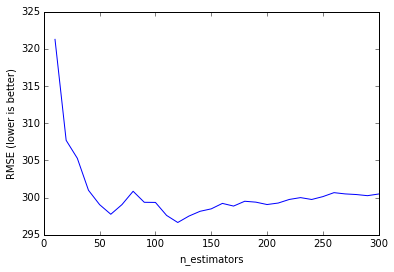

In [35]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

### Tuning max_features for RandomForestRegressor

The other important tuning parameter is **max_features**, which is the number of features that should be considered at each split.

In [36]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

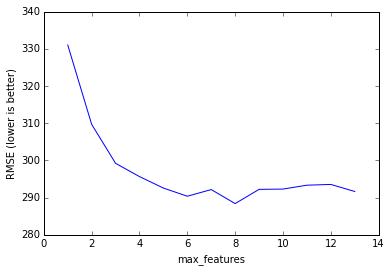

In [37]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

In [38]:
# show the best RMSE and the corresponding max_features
sorted(zip(RMSE_scores, feature_range))[0]

(288.41877774269841, 8)

## Comparing Random Forests with decision trees

**Advantages of Random Forests:**

- Performance is competitive with the best supervised learning methods
- Provides a more reliable estimate of feature importance
- Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**

- Less interpretable
- Slower to train
- Slower to predict

![Machine learning flowchart](images/driver_ensembling.png)

*Machine learning flowchart created by the [second place finisher](http://blog.kaggle.com/2015/04/20/axa-winners-interview-learning-telematic-fingerprints-from-gps-data/) of Kaggle's [Driver Telematics competition](https://www.kaggle.com/c/axa-driver-telematics-analysis)*